# NEI Solver
Using the ionization and recombination rates calculated with fiasco, test methods for solving the nonequilibrium ionization equations.

In [1]:
import os
import sys

import numpy as np
import plasmapy
import scipy.interpolate
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn.apionly as sns
import astropy.units as u
import hissw
import fiasco

sys.path.append('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/rsp_toolkit/python/')
from xml_io import InputHandler,OutputHandler

%matplotlib inline

/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Reading apolloDB/IonPopSolver Data

In [2]:
def read_ips_balance(element):
    with open('/Users/willbarnes/Documents/work/codes/apolloDB/balances/ips_01dex/{}.bal'.format(element.lower()),
              'r') as f:
        lines = f.readlines()
    ioneq = np.zeros((len(lines),len(lines[0].split())-1),dtype=np.float64)
    temperature_grid= np.zeros((len(lines),),dtype=np.float64)
    for i,line in enumerate(lines):
        line = line.split()
        temperature_grid[i] = line[0]
        ioneq[i,:] = line[1:]
        
    return temperature_grid,ioneq

In [3]:
def read_ips_rates(element,temperature_grid):
    with open('/Users/willbarnes/Documents/work/codes/apolloDB/rates/ips_01dex/{}.rts'.format(element.lower()), 'r') as f:
        lines = f.readlines()
    rates = {'ionization':{},'recombination':{}}
    current_ds = 'ionization'
    for l in lines:
        if not l.strip():
            continue
        if element.capitalize() in l:
            ion_name = l.strip()
            if ion_name in rates[current_ds]:
                current_ds = 'recombination'
            rates[current_ds][ion_name] = []
            continue
        rates[current_ds][ion_name] += l.strip().split()
    for k in rates['ionization']:
        rates['ionization'][k] = np.array(rates['ionization'][k],dtype=np.float64)
    last_charge_state = int(k.split('+')[1])+1
    # ionization rate of fully-ionized should be 0
    rates['ionization'][f'{element.capitalize()}+{last_charge_state}'] = np.zeros(temperature_grid.shape) 
    for k in rates['recombination']:
        rates['recombination'][k] = np.array(rates['recombination'][k],dtype=np.float64)
    rev_keys = sorted(rates['recombination'].keys(),key=lambda x:int(x.split('+')[1]),reverse=True)
    for rk in rev_keys:
        charge_state = int(rk.split('+')[1])
        new_key = f'{element.capitalize()}+{charge_state+1}'
        rates['recombination'][new_key] = rates['recombination'][rk]
    rates['recombination'][rk] = np.zeros(temperature_grid.shape)
    
    return rates

Now, let's compare the two sets of ionization and recombination rates.

In [225]:
temperature_grid,ioneq_ips = read_ips_balance('Fe')
rates = read_ips_rates('Fe',temperature_grid)

In [226]:
el = fiasco.Element('Fe',10.**temperature_grid*u.K)

Ionization rates

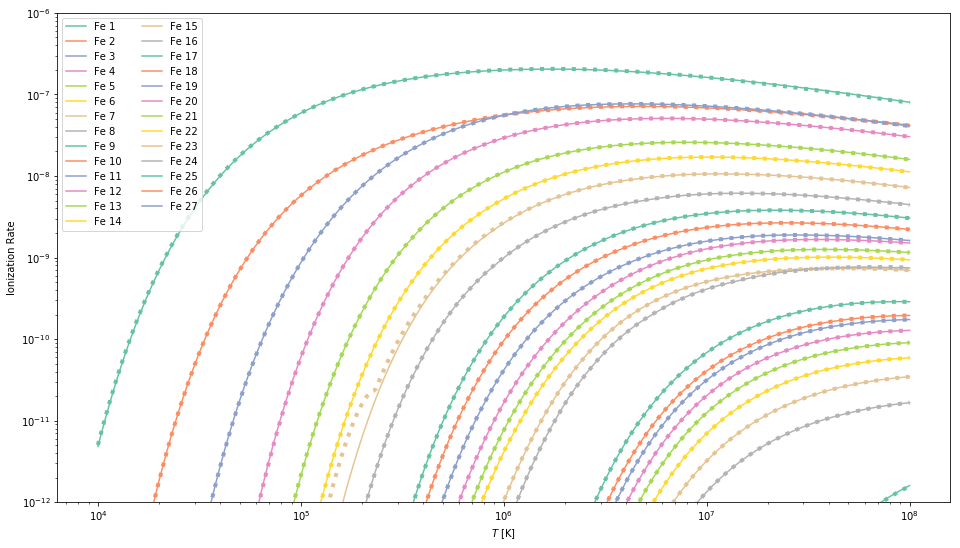

In [229]:
plt.figure(figsize=(16,9))
colors = sns.color_palette('Set2',n_colors=el.atomic_number+1)
for ion in el:
    plt.plot(el.temperature,ion.ionization_rate(), color=colors[ion.charge_state],ls='-',label=ion.ion_name)
    plt.plot(10.**temperature_grid,rates['ionization'][f'{ion.atomic_symbol}+{ion.charge_state}'],
             color=colors[ion.charge_state],ls=':',lw=4)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-12,1e-6])
plt.xlabel(r'$T$ [K]')
plt.ylabel(r'Ionization Rate')
plt.legend(ncol=2)

Recombination Rates

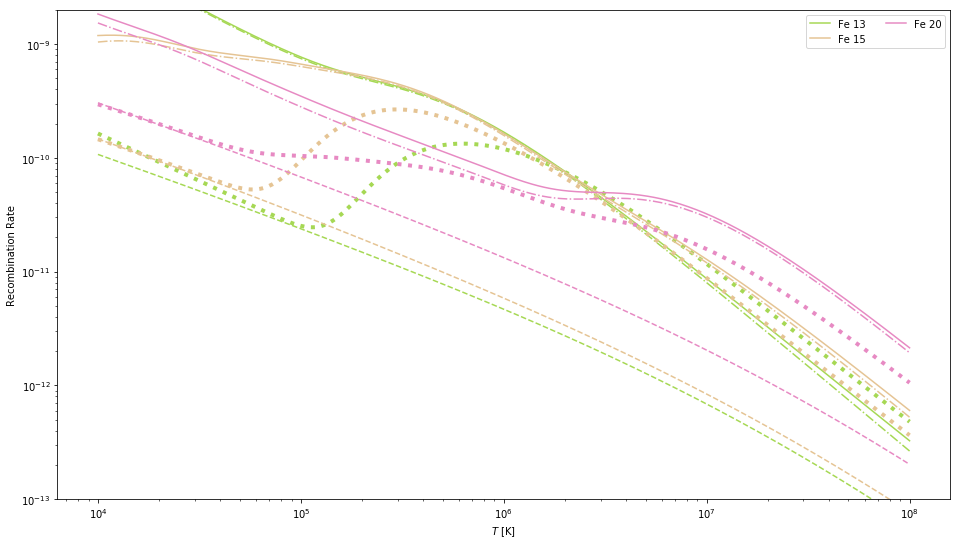

In [252]:
plt.figure(figsize=(16,9))
plot_these_ions = [13,15,20]
colors = sns.color_palette('Set2',n_colors=el.atomic_number+1)
for ion in el:
    if ion.ionization_stage not in plot_these_ions:
        continue
    color = colors[ion.charge_state]
    plt.plot(el.temperature,ion.recombination_rate(),ls='-',label=ion.ion_name,color=color)
    rr_rate = ion.radiative_recombination_rate()
    if rr_rate is not None:
        plt.plot(el.temperature,rr_rate,color=color,ls='--')
    dr_rate = ion.dielectronic_recombination_rate()
    if dr_rate is not None:
        plt.plot(el.temperature,dr_rate,color=color,ls='-.')
    plt.plot(10.**temperature_grid,
             rates['recombination'][f'{ion.atomic_symbol}+{ion.charge_state}'],
         color=color,ls=':',lw=4)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-13,2e-9])
plt.xlabel(r'$T$ [K]')
plt.ylabel(r'Recombination Rate')
plt.legend(ncol=2)

In [253]:
for ion in el:
    print(ion._drparams)

None
fe/fe_2/drparams -- v8.0.2

Fields
------
E_fit (K) -- E fit parameter
c_fit (cm3 K(3/2) / s) -- c fit parameter
fit_type  -- fit type

Footer
------
file:  fe_2.rrparams
parameters for dielectronic recombination rate coefficients
reference:  Mazzotta, P., Mazzitelli, G., Colafrancesco, S.,
Vittorio, N., 1998, A\&ASS, 133, 403
produced for the CHIANTI atomic database for astrophysical spectroscopy
created by Ken Dere (GMU):  Thu Feb  8 15:10:19 2007
fe/fe_3/drparams -- v8.0.2

Fields
------
E_fit (K) -- E fit parameter
c_fit (cm3 K(3/2) / s) -- c fit parameter
fit_type  -- fit type

Footer
------
file:  fe_3.rrparams
parameters for dielectronic recombination rate coefficients
reference:  Mazzotta, P., Mazzitelli, G., Colafrancesco, S.,
Vittorio, N., 1998, A\&ASS, 133, 403
produced for the CHIANTI atomic database for astrophysical spectroscopy
created by Ken Dere (GMU):  Thu Feb  8 15:10:19 2007
fe/fe_4/drparams -- v8.0.2

Fields
------
E_fit (K) -- E fit parameter
c_fit (cm3 K(3/2

Ionization equilibrium

In [8]:
ioneq = el.ionization_equilibrium()

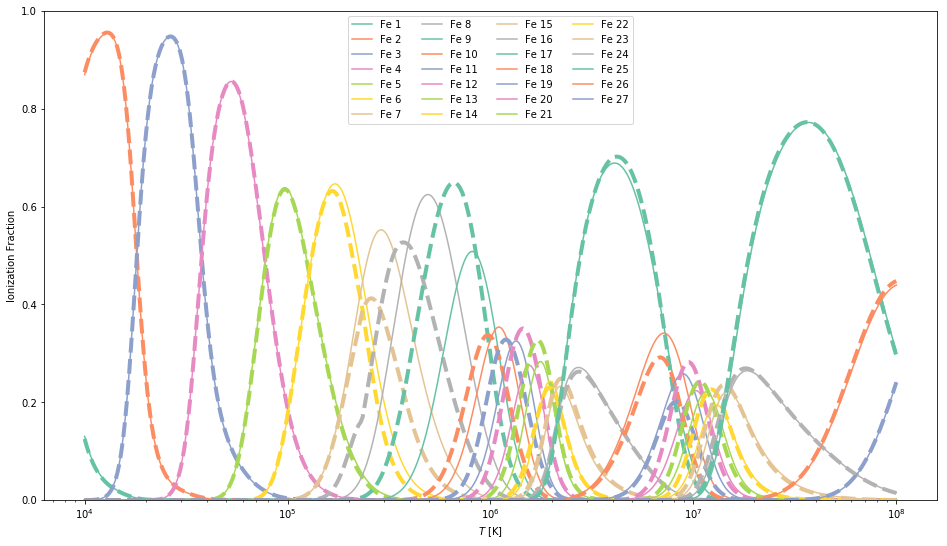

In [9]:
plt.figure(figsize=(16,9))
colors = sns.color_palette('Set2',n_colors=el.atomic_number+1)
for ion in el:
    color = color=colors[ion.charge_state]
    plt.plot(el.temperature,ioneq[:,ion.charge_state],ls='-',label=ion.ion_name,color=color)
    plt.plot(10.**temperature_grid,ioneq_ips[:,ion.charge_state],
         color=color,ls='--',lw=4)
plt.xscale('log')
plt.ylim(0,1)
plt.xlabel(r'$T$ [K]')
plt.ylabel(r'Ionization Fraction')
plt.legend(ncol=4)

## Test Data

In [140]:
time = np.linspace(0,100,1000)
## timescales
t_rise_T,t_peak_T,t_end_T = 0,10,20
t_rise_n,t_peak_n,t_end_n = 0,30,100
T_start,T_peak,T_end = 1e5,1e7,1e5
n_start,n_peak,n_end = 1e8,1e10,1e8
## temperature
temperature = np.zeros(time.shape)#T_start*np.ones(time.shape)
temperature = np.where(time<=t_rise_T,T_start, temperature)
temperature = np.where(time>=t_end_T, T_end, temperature)
temperature = np.where(np.logical_and(time>t_rise_T,time<t_peak_T),
                       (time - t_rise_T)*(T_peak-T_start)/(t_peak_T - t_rise_T) + T_start, temperature)
temperature = np.where(np.logical_and(time>=t_peak_T,time<t_end_T),
                       (time - t_peak_T)*(T_end - T_peak)/(t_end_T - t_peak_T) + T_peak, temperature)
## density
density = np.zeros(time.shape)
density = np.where(time<=t_rise_n,n_start, density)
density = np.where(time>=t_end_n, n_end, density)
density = np.where(np.logical_and(time>t_rise_n,time<t_peak_n),
                    (time - t_rise_n)*(n_peak-n_start)/(t_peak_n - t_rise_n) + n_start, density)
density = np.where(np.logical_and(time>=t_peak_n,time<t_end_n),
                    (time - t_peak_n)*(n_end - n_peak)/(t_end_n - t_peak_n) + n_peak, density)

(0.01, 10)

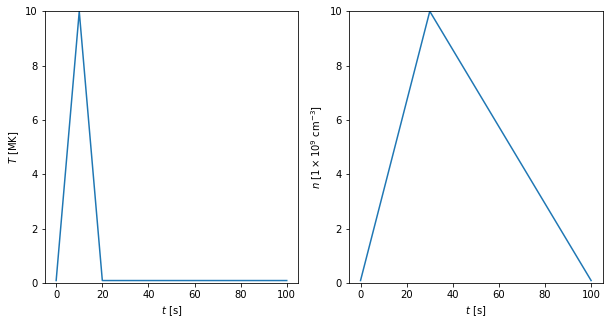

In [202]:
plt.figure(figsize=(10,5))
plt.subplot(121).plot(time,temperature/1e6)
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$T$ [MK]')
plt.ylim([0.01,10])
plt.subplot(122).plot(time,density/1e9)
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$n$ [$1\times10^9$ cm$^{-3}$]')
plt.ylim([0.01,10])

## IonPopSolver Simulation

In [142]:
np.savetxt('simple_test.ips.input',np.vstack([time,temperature,density]).T,
           header='{}'.format(time.shape[0]),comments='',fmt='%f\t%e\t%e')

In [143]:
%%bash
/Users/willbarnes/Documents/work/codes/IonPopSolver/bin/IonPopSolver.run -Z 26 -f 1 -t 27 \
-I simple_test.ips.input \
-O simple_test.ips.output \
-r /Users/willbarnes/Documents/work/codes/IonPopSolver/test/radiation.local.cfg.xml

0%|         |100%
  |||||||||||

The process took 3.000000 seconds to run.


In [144]:
tmp = np.loadtxt('simple_test.ips.output')
time_ips = tmp[:,0]
y_ips = tmp[:,4:]

(0, 1)

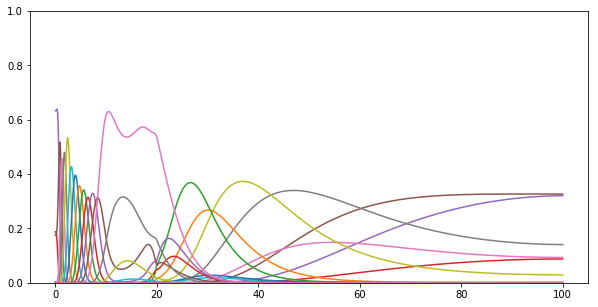

In [145]:
plt.figure(figsize=(10,5))
plt.plot(time_ips,y_ips);
plt.ylim([0,1])

## Solvers
We want to solve the ionization and recombination equations which can be written as,

$$
\frac{dY_i}{dt} = n(I_{i-1}Y_{i-1} + R_{i+1}Y_{i+1} - Y_i(R_i + I_i))
$$

such that we have $Z+1$ coupled differential equations. In matrix form, this can be written as,

$$
\frac{d}{dt}\mathbf{Y} = n\mathbf{A}\mathbf{Y}
$$

where $\mathbf{Y}\in\mathbb{R}^{Z+1}$, $\mathbf{A}\in\mathbb{R}^{Z+1\times Z+1}$.

### Implicit Solver
For a "corrector-predictor" update rule of the form,

$$
\mathbf{Y}_{n+1} = \mathbf{Y}_n + \frac{h}{2}\left(\dot{\mathbf{Y}}_{n} + \dot{\mathbf{Y}}_{n+1}\right),
$$
the update for $Y$ becomes,

$$
\mathbf{Y}_{n+1} = \left(\mathbb{1} - \frac{h}{2}n_{n+1}\mathbf{A}_{n+1}\right)^{-1}\left(\mathbb{1} + \frac{h}{2}n_n\mathbf{A_n}\right)\mathbf{Y}_n
$$

In [146]:
def nei_implicit_ips_rates(time,temperature,density,element):
    temperature_grid,ioneq = read_ips_balance(element)
    rates = read_ips_rates(element,temperature_grid)
    temperature_grid = 10.**temperature_grid
    irates = rates['ionization']
    rrates = rates['recombination']
    atomic_number = plasmapy.atomic.atomic_number(element)
    a_matrix = np.zeros(temperature_grid.shape+(atomic_number+1,atomic_number+1))
    for i in range(1,atomic_number):
        a_matrix[:,i,i] = -(irates[f'{element}+{i}'] + rrates[f'{element}+{i}'])
        a_matrix[:,i,i-1] = irates[f'{element}+{i-1}']
        a_matrix[:,i,i+1] = rrates[f'{element}+{i+1}']
    a_matrix[:,0,0] = -(irates[f'{element}+{0}'] + rrates[f'{element}+{0}'])
    a_matrix[:,0,1] = rrates[f'{element}+{1}']
    a_matrix[:,-1,-1] = -(irates[f'{element}+{atomic_number}'] + rrates[f'{element}+{atomic_number}'])
    a_matrix[:,-1,-2] = rrates[f'{element}+{atomic_number-1}']
    # Interpolation and allocation
    interp_indices = [np.abs(temperature_grid - temp).argmin() for temp in temperature]
    y = np.zeros(time.shape+(atomic_number+1,))
    y[0,:] = ioneq[interp_indices[0],:]
    # Solve
    for i in range(1,time.shape[0]):
        dt = time[i] - time[i-1]
        term1 = np.eye(atomic_number+1) - density[i]*dt/2.*a_matrix[interp_indices[i],:,:]
        term2 = np.eye(atomic_number+1) + density[i-1]*dt/2.*a_matrix[interp_indices[i-1],:,:]
        y[i,:] = np.linalg.inv(term1) @ term2 @ y[i-1,:]
        y[i,:] /= y[i,:].sum()

    return y

In [147]:
def nei_implicit(time,temperature,density,element,temperature_grid):
    """
    Solve NEI equations.
    """
    # Atomic Data
    el = fiasco.Element(element,temperature_grid)
    ioneq = el.ionization_equilibrium()
    a_matrix = np.zeros(temperature_grid.shape+(el.atomic_number+1,el.atomic_number+1))
    for i in range(1,el.atomic_number):
        a_matrix[:,i,i] = -(el[i].ionization_rate() + el[i].recombination_rate()).value
        a_matrix[:,i,i-1] = el[i-1].ionization_rate().value
        a_matrix[:,i,i+1] = el[i+1].recombination_rate().value
    a_matrix[:,0,0] = -(el[0].ionization_rate() + el[0].recombination_rate()).value
    a_matrix[:,0,1] = el[1].recombination_rate().value
    a_matrix[:,-1,-1] = -(el[-1].ionization_rate() + el[-1].recombination_rate()).value
    a_matrix[:,-1,-2] = el[-2].ionization_rate().value
    # Interpolation and allocation
    interp_indices = [np.abs(temperature_grid.value - temp).argmin() for temp in temperature]
    y = np.zeros(time.shape+(el.atomic_number+1,))
    y[0,:] = ioneq[interp_indices[0],:]
    # Solve
    for i in range(1,time.shape[0]):
        dt = time[i] - time[i-1]
        term1 = np.eye(el.atomic_number+1) - density[i]*dt/2.*a_matrix[interp_indices[i],:,:]
        term2 = np.eye(el.atomic_number+1) + density[i-1]*dt/2.*a_matrix[interp_indices[i-1],:,:]
        y[i,:] = np.linalg.inv(term1) @ term2 @ y[i-1,:]
        y[i,:] /= y[i,:].sum()

    return y

In [130]:
temperature_grid = 10.**(np.arange(4,8,0.01))*u.K
y_implicit = nei_implicit(time,temperature,density,'iron',temperature_grid)

In [148]:
y_implicit_ips = nei_implicit_ips_rates(time,temperature,density,'Fe')

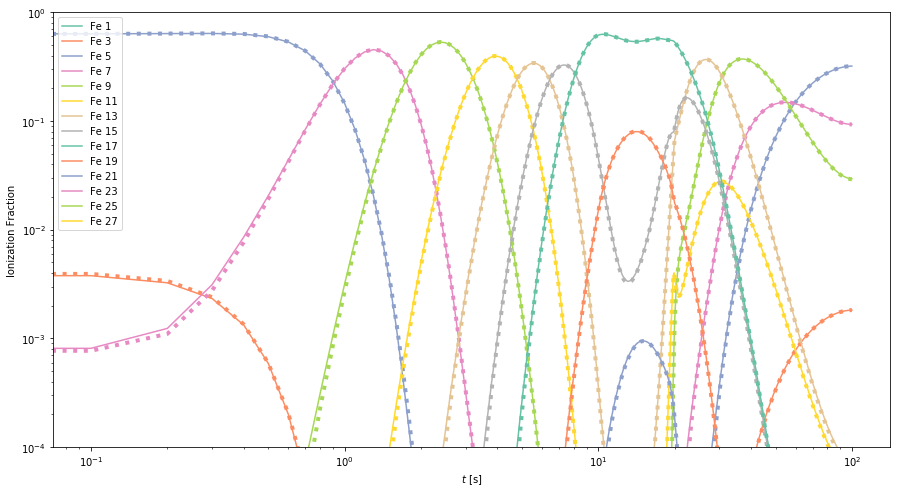

In [235]:
ions = list(range(y_implicit_ips.shape[1]))
plt.figure(figsize=(15,8))
colors = sns.color_palette('Set2',n_colors=len(ions))
#interp_indices = [np.abs(temperature_grid.va - temp).argmin() for temp in temperature]
for i,ion in enumerate(ions[::2]):
    color = colors[i]
    #plt.plot(time,ioneq[interp_indices,i_ion],ls=':',color=colors[i_ion],)
    #plt.plot(time,y_implicit[:,ion],ls='-.',color=color)
    plt.plot(time,y_implicit_ips[:,ion],ls='-',color=color,label=r'Fe {}'.format(ion+1))
    plt.plot(time_ips,y_ips[:,ion],ls=':',color=color,lw=4)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-4,1])
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'Ionization Fraction')
#plt.xlim([80,100])
plt.legend()

## Check Stability Conditions

In [ ]:
y_diff = np.fabs(y_implicit[1:] - y_implicit[:-1])
plt.figure(figsize=(10,10))
colors = sns.color_palette('Set2',n_colors=y_diff.shape[1])
for i in range(y_implicit.shape[1]):
    plt.plot(time[1:],y_diff[:,i],color=colors[i],label='{}'.format(i+1))
plt.axhline(y=0.1,ls=':',color='k')
plt.yscale('log')
plt.ylim([1e-10,0.2])
#plt.xlim([20,40])
plt.legend()

In [ ]:
y_diff = np.fabs(y_ips[1:] - y_ips[:-1])
plt.figure(figsize=(10,10))
colors = sns.color_palette('Set2',n_colors=y_diff.shape[1])
for i in range(y_implicit.shape[1]):
    plt.plot(time_ips[1:],y_diff[:,i],color=colors[i],label='{}'.format(i+1))
plt.axhline(y=0.1,ls=':',color='k')
plt.yscale('log')
plt.ylim([1e-10,0.2])
#plt.xlim([20,40])
plt.legend()

In [ ]:
y_ratio = y_implicit[1:]/y_implicit[:-1]
plt.figure(figsize=(10,10))
colors = sns.color_palette('Set2',n_colors=y_diff.shape[1])
for i in range(y_implicit.shape[1]):
    plt.plot(time[1:],y_ratio[:,i],color=colors[i],label='{}'.format(i+1))
plt.axhline(y=10.**(0.6),color='k',ls=':')
plt.axhline(y=10.**(-0.6),color='k',ls=':')
plt.yscale('log')
plt.ylim([1e-2,100])
plt.legend()

In [ ]:
y_ratio = y_ips[1:]/y_ips[:-1]
plt.figure(figsize=(10,10))
colors = sns.color_palette('Set2',n_colors=y_diff.shape[1])
for i in range(y_implicit.shape[1]):
    plt.plot(time_ips[1:],y_ratio[:,i],color=colors[i],label='{}'.format(i+1))
plt.axhline(y=10.**(0.6),color='k',ls=':')
plt.axhline(y=10.**(-0.6),color='k',ls=':')
plt.yscale('log')
plt.ylim([1e-2,100])
plt.legend()

In [ ]:
el = fiasco.Element('iron',temperature_grid)

In [ ]:
for i in [7,8,9]:
    plt.plot(el.temperature,el[i].ionization_rate(),label='ionization rate, {}'.format(el[i].ion_name))
    plt.plot(el.temperature,el[i].recombination_rate(),label='recombination rate, {}'.format(el[i].ion_name))
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-11,1e-7])
plt.legend(ncol=2)

### Eigenvalue Solver
An alternative solution (explored by Shen et al., 2015) is to diagonalize $\mathbf{A}$ and solve $Z+1$ individual differential equations. Recall that $\mathbf{A}$ can be written as,

$$
\mathbf{A} = \mathbf{V}\Lambda\mathbf{V}^{-1}
$$

where diagonal entries of $\Lambda$ are the eigenvalues of $\mathbf{A}$ and the columns of $\mathbf{V}$ are the eigenvectors of $\mathbf{A}$. Thus, our differential equation can be written as,

$$
\begin{align}
\frac{d}{dt}\mathbf{Y} &= n\mathbf{V}\Lambda\mathbf{V}^{-1}\mathbf{Y} \\
\mathbf{V}^{-1}\frac{d}{dt}\mathbf{Y} &= \mathbf{V}^{-1}n\mathbf{V}\Lambda\mathbf{V}^{-1}\mathbf{Y} \\
\frac{d}{dt}(\mathbf{V}^{-1}\mathbf{Y}) &= n\mathbf{V}^{-1}\mathbf{V}\Lambda(\mathbf{V}^{-1}\mathbf{Y}) \\
\frac{d}{dt}\mathscr{Y} &= n\Lambda\mathscr{Y}
\end{align}
$$

where $\mathscr{Y}=\mathbf{V}^{-1}\mathbf{Y}$. Note that this gives $Z+1$ independent differential equations. For an interval $[t_{j+1},t_j]$ such that $|T_{j+1}-T_j|<\varepsilon$, the expression for ion $i$ becomes,

$$
\mathscr{Y}_{i,j+1} = \exp{\left[n_{j+1}\lambda_{i,j+1}(t_{j+1}-t_j)\right]}\mathscr{Y}_{i,j}
$$

so our matrix expression for $\mathbf{Y}_{j+1}$ becomes,

$$
\mathbf{Y}_{j+1} = \mathbf{V}_{j+1}\exp{\left[n_{j+1}\Lambda_{j+1}(t_{j+1}-t_j)\right]}\mathbf{V}^{-1}_j\mathbf{Y}_j
$$

In [ ]:
eigval,eigvec = np.linalg.eig(a_matrix)

In [ ]:
y_eigen = np.zeros(time.shape+(el.atomic_number+1,))
y_eigen[0,:] = ioneq[interp_indices[0],:]

In [ ]:
for i in range(1,time.shape[0]):
    j = interp_indices[i]
    term = np.exp(density[i]*(time[i] - time[i-1])*eigval[j,:]*np.eye(el.atomic_number+1))
    y_eigen[i,:] = eigvec[j,:,:] @ term @ np.linalg.inv(eigvec[j,:,:]) @ y_eigen[i-1,:]
    y_eigen[i,:] = np.where(y_eigen[i,:]<0,0,y_eigen[i,:])
    y_eigen[i,:] /= y_eigen[i,:].sum()

In [ ]:
plt.plot(time,y_eigen);
plt.ylim([0,1])

## Another Example: EBTEL Output

Configure and run an EBTEL simulation

In [84]:
base_config = InputHandler('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml').lookup_vars()
base_config['heating']['events'] = [
    {'event':{'decay_start':100,'decay_end':200,'rise_start':0,'rise_end':100,'magnitude':0.1}},
    #{'event':{'decay_start':2600,'decay_end':2700,'rise_start':2500,'rise_end':2600,'magnitude':0.5}}
]
base_config['heating']['background'] = 1e-6
base_config['output_filename'] = 'ebtel_test'
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['use_flux_limiting'] = True
base_config['adaptive_solver_error'] = 1e-8
base_config['adaptive_solver_safety'] = 0.5
#base_config['tau_max'] = 
oh = OutputHandler(base_config['output_filename']+'.xml',base_config)
oh.print_to_xml()

In [85]:
%%bash
/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/bin/ebtel++.run -c ebtel_test.xml

In [86]:
tmp = np.loadtxt('ebtel_test')
time_ebtel = tmp[:,0]
temperature_ebtel = tmp[:,1]
density_ebtel = tmp[:,3]

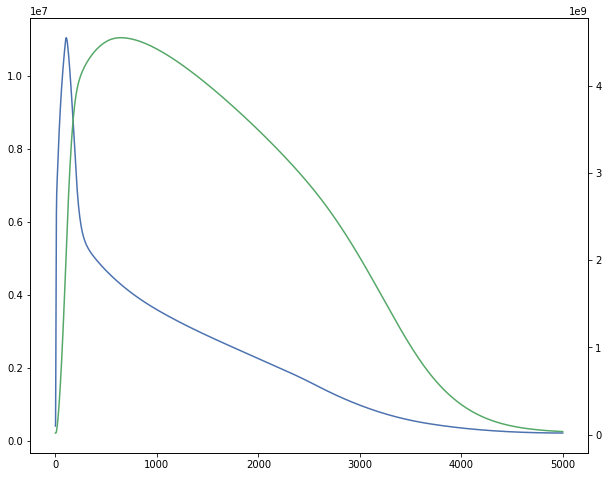

In [87]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax.plot(time_ebtel,temperature_ebtel,ls='-',color=sns.color_palette('deep')[0])
ax2 = ax.twinx()
ax2.plot(time_ebtel,density_ebtel,ls='-',color=sns.color_palette('deep')[1])
#ax.set_xlim([0,50])
#ax2.set_ylim([0,200])

Run the IonPopSolver code

In [88]:
np.savetxt('ebtel_test.ips.input',np.vstack([time_ebtel,temperature_ebtel,density_ebtel]).T,
           header='{}'.format(time_ebtel.shape[0]),comments='',fmt='%f\t%e\t%e')

In [89]:
%%bash
/Users/willbarnes/Documents/work/codes/IonPopSolver/bin/IonPopSolver.run \
-Z 26 -f 1 -t 27 \
-I ebtel_test.ips.input \
-O ebtel_test.ips.output \
-r /Users/willbarnes/Documents/work/codes/IonPopSolver/test/radiation.local.cfg.xml

0%|         |100%
  |||||||||||

The process took 9.000000 seconds to run.


In [90]:
tmp = np.loadtxt('ebtel_test.ips.output')
time_ebtel_ips = tmp[:,0]
y_ebtel_ips = tmp[:,4:]

Run the implicit solver

In [91]:
temperature_grid = 10.**(np.arange(4,8,0.001))*u.K
y_implicit_ebtel = nei_implicit(time_ebtel,temperature_ebtel,density_ebtel,'Fe',temperature_grid)

In [92]:
y_implicit_ebtel_ips = nei_implicit_ips_rates(time_ebtel,temperature_ebtel,density_ebtel,'Fe')

And compare

(0, 0.75)

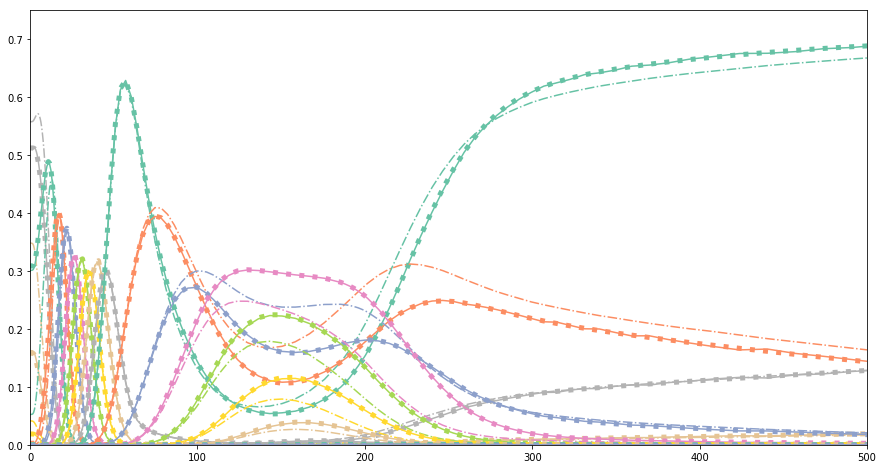

In [94]:
plt.figure(figsize=(15,8))
ions = list(range(y_implicit_ebtel_ips.shape[1]))
colors = sns.color_palette('Set2',n_colors=y_implicit_ebtel_ips.shape[1])
for ion in ions:
    color = colors[ion]
    plt.plot(time_ebtel,y_implicit_ebtel_ips[:,ion],ls='-',color=color,label=r'Fe {}'.format(ion+1))
    plt.plot(time_ebtel,y_implicit_ebtel[:,ion],ls='-.',color=color)
    plt.plot(time_ebtel_ips,y_ebtel_ips[:,ion],color=color,ls=':',lw=5)
#plt.xscale('log')
#plt.xlim([0,500])
plt.ylim([0,.75])
#plt.legend()

## Sandbox

In [ ]:
el = fiasco.Element('iron',temperature_grid)

In [ ]:
ioneq_fiasco = el.ionization_equilibrium()

In [ ]:
plt.figure(figsize=(15,8))
colors = sns.color_palette('Set2',n_colors=ioneq_ips.shape[1])
for i in range(ioneq_ips.shape[1]):
    plt.plot(10.**(temperature_grid_ips),ioneq_ips[:,i],color=colors[i]);
    #plt.plot(temperature_grid,ioneq_fiasco[:,i],ls='-',color=colors[i]);
for i,ion in enumerate(el):
    plt.plot(temperature_grid,ion.ioneq,ls=':',color=colors[i])
plt.xscale('log')

In [254]:
foo = np.random.rand(10,5)
bar = u.Quantity(np.random.rand(10,5))

In [255]:
foo[:,0] = bar[:,0]